## Import Library

In [34]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [35]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [36]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

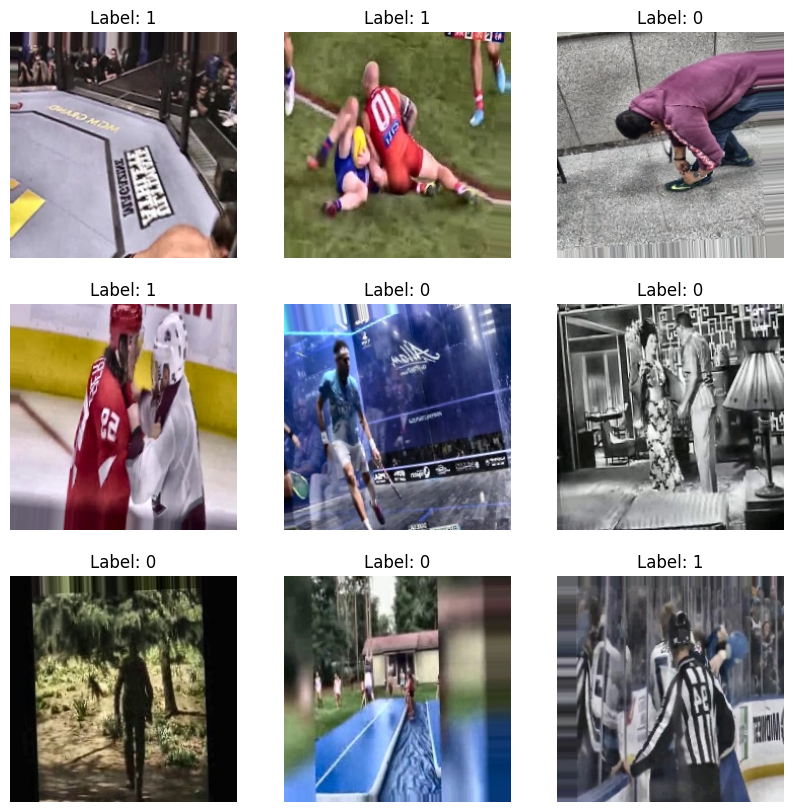

In [37]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [38]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_NoFreeze_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 15,110,465 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [39]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.5574 - loss: 1.3986
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 798ms/step - accuracy: 0.5581 - loss: 1.3973 - val_accuracy: 0.5000 - val_loss: 14.2928
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6676 - loss: 1.1664
Epoch 2: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.6680 - loss: 1.1658 - val_accuracy: 0.5000 - val_loss: 4.7592
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7232 - loss: 1.1173
Epoch 3: val_accuracy improved from 0.50000 to 0.50909, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - accuracy: 0.7235 - loss: 1.1161 - val_accuracy: 0.5091 - val_loss: 2.6544
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7660 - loss: 0.9928
Epoch 4: val_accuracy improved from 0.50909 to 0.63182, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 713ms/step - accuracy: 0.7660 - loss: 0.9924 - val_accuracy: 0.6318 - val_loss: 1.1878
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7932 - loss: 0.9074
Epoch 5: val_accuracy did not improve from 0.63182
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 748ms/step - accuracy: 0.7924 - loss: 0.9090 - val_accuracy: 0.5000 - val_loss: 3.4960
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7505 - loss: 0.9565
Epoch 6: val_accuracy did not improve from 0.63182
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 729ms/step - accuracy: 0.7507 - loss: 0.9561 - val_accuracy: 0.5000 - val_loss: 4.6077
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.8189 - loss: 0.8324
Epoch 7: val_accuracy improved from 0.63182 to 0.65000, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 779ms/step - accuracy: 0.8188 - loss: 0.8325 - val_accuracy: 0.6500 - val_loss: 1.4410
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7965 - loss: 0.8367
Epoch 8: val_accuracy did not improve from 0.65000
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 706ms/step - accuracy: 0.7967 - loss: 0.8362 - val_accuracy: 0.5068 - val_loss: 3.4211
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8411 - loss: 0.7619
Epoch 9: val_accuracy did not improve from 0.65000
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 694ms/step - accuracy: 0.8410 - loss: 0.7618 - val_accuracy: 0.5000 - val_loss: 5.9322
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8525 - loss: 0.6886
Epoch 10: val_accuracy did not improve from 0.65000
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - accuracy: 0.8524 - loss: 0.6888 - val_accuracy: 0.5000 - val_loss: 3.9031
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8757 - loss: 0.6736
Epoch 11: val_accuracy did n

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 687ms/step - accuracy: 0.8664 - loss: 0.6593 - val_accuracy: 0.6545 - val_loss: 1.9420
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8782 - loss: 0.6775
Epoch 13: val_accuracy improved from 0.65455 to 0.88409, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - accuracy: 0.8783 - loss: 0.6764 - val_accuracy: 0.8841 - val_loss: 0.6000
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8864 - loss: 0.6221
Epoch 14: val_accuracy did not improve from 0.88409
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.8866 - loss: 0.6212 - val_accuracy: 0.5000 - val_loss: 4.4286
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8919 - loss: 0.5690
Epoch 15: val_accuracy did not improve from 0.88409
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 736ms/step - accuracy: 0.8919 - loss: 0.5693 - val_accuracy: 0.5591 - val_loss: 2.9107
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8900 - loss: 0.5589
Epoch 16: val_accuracy did not improve from 0.88409
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 695ms/step - accuracy: 0.8899 - loss: 0.5591 - val_accuracy: 0.8455 - val_loss: 0.6840
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9026 - loss: 0.5225
Epoch 17: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 698ms/step - accuracy: 0.9348 - loss: 0.4264 - val_accuracy: 0.8977 - val_loss: 0.5120
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9302 - loss: 0.4366
Epoch 21: val_accuracy did not improve from 0.89773
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - accuracy: 0.9304 - loss: 0.4363 - val_accuracy: 0.8364 - val_loss: 0.7154
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9450 - loss: 0.4041
Epoch 22: val_accuracy improved from 0.89773 to 0.92727, saving model to MCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 687ms/step - accuracy: 0.9448 - loss: 0.4043 - val_accuracy: 0.9273 - val_loss: 0.4542
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9196 - loss: 0.4687
Epoch 23: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 682ms/step - accuracy: 0.9191 - loss: 0.4707 - val_accuracy: 0.5955 - val_loss: 3.7120
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.7908 - loss: 0.8233
Epoch 24: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 690ms/step - accuracy: 0.7910 - loss: 0.8212 - val_accuracy: 0.5000 - val_loss: 6.8270
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8223 - loss: 0.6669
Epoch 25: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 680ms/step - accuracy: 0.8225 - loss: 0.6665 - val_accuracy: 0.8068 - val_loss: 0.7523
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8732 - loss: 0.5726
Epoch 26: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.9602 - loss: 0.2510 - val_accuracy: 0.9318 - val_loss: 0.3618
Epoch 48/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9689 - loss: 0.2461
Epoch 48: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.9689 - loss: 0.2459 - val_accuracy: 0.8341 - val_loss: 0.7420
Epoch 49/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9698 - loss: 0.2255
Epoch 49: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.9697 - loss: 0.2256 - val_accuracy: 0.6045 - val_loss: 2.0690
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9743 - loss: 0.2255
Epoch 50: val_accuracy did not improve from 0.93182
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - accuracy: 0.9744 - loss: 0.2252 - val_accuracy: 0.8864 - val_loss: 0.5193


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9559 - loss: 0.2825
Validation Loss: 0.5193257927894592
Validation Accuracy: 0.8863636255264282


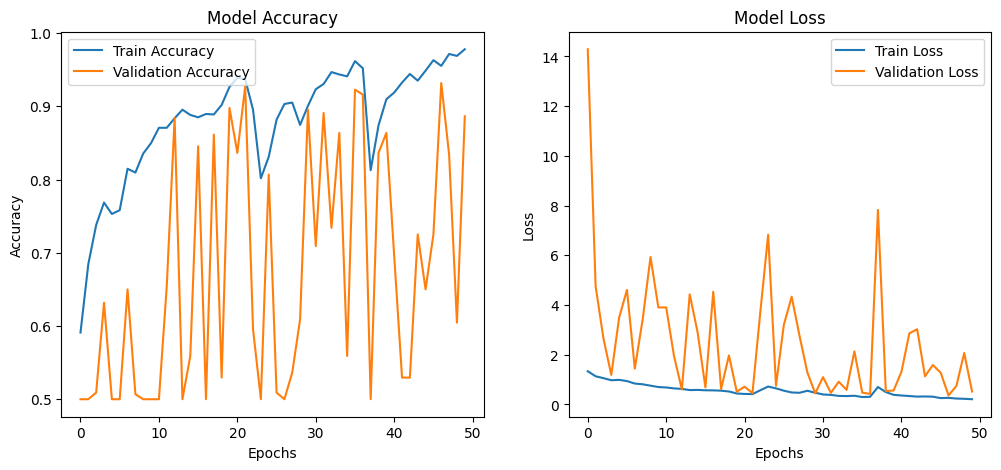

In [40]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [41]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_NoFreeze_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.9283 - loss: 0.3365
Test Accuracy : 93.69%
Test Loss     : 0.323


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step


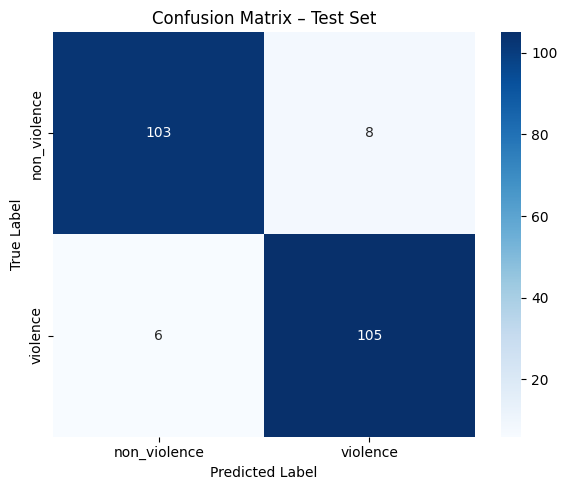


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.94      0.93      0.94       111
    violence       0.93      0.95      0.94       111

    accuracy                           0.94       222
   macro avg       0.94      0.94      0.94       222
weighted avg       0.94      0.94      0.94       222



In [42]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))